In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from astropy.table import QTable, Table

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# setup

In [2]:
col_format_all_S17 = {
    'NAME':pd.StringDtype(),
    'RA':np.float64, 'DEC':np.float64,
    'PMRA':np.float32, 'PMDEC':np.float32,
    'EPOCH':np.float32, 'RESOLUTION':np.int16,
    'SUBSURVEY':pd.StringDtype(),
    'TEMPLATE':pd.StringDtype(), 
    'RULESET':pd.StringDtype(),
    'EXTENT_FLAG':np.int32,
    'EXTENT_PARAMETER':np.float32,'EXTENT_INDEX':np.float32,
    'MAG_TYPE':pd.StringDtype(),
    'MAG':np.float32, 'MAG_ERR':np.float32,
    'DATE_EARLIEST':np.float64, 'DATE_LATEST':np.float64,
    'CADENCE':np.int64,
    'REDDENING':np.float32,
    'REDSHIFT_ESTIMATE':np.float32,
    'REDSHIFT_ERROR':np.float32,
    'CAL_MAG_ID_BLUE':pd.StringDtype(),
    'CAL_MAG_ID_GREEN':pd.StringDtype(),
    'CAL_MAG_ID_RED':pd.StringDtype(),
    'CAL_MAG_ERR_BLUE':np.float32,
    'CAL_MAG_ERR_GREEN':np.float32,
    'CAL_MAG_ERR_RED':np.float32,
    'CAL_MAG_BLUE':np.float32,
    'CAL_MAG_GREEN':np.float32,
    'CAL_MAG_RED':np.float32,
    'CLASSIFICATION':pd.StringDtype(),
    'CLASS_SPEC':pd.StringDtype(),
    'COMPLETENESS':np.float32,
    'PARALLAX':np.float32,
    'SWEEP_NAME':pd.StringDtype(), 
    'BRICKNAME':pd.StringDtype(), 
    'TYPE':pd.StringDtype(), 
    'BAND_LEGACY':pd.StringDtype(), 
    'REFERENCE_BAND':pd.StringDtype(), 
    'COMBINATION_USE':pd.StringDtype(), 
    'REDSHIFT_REF':pd.StringDtype(), 
    'EBV':np.float64, 
    'PLXSIG': np.float64, 
    'PMSIG': np.float64, 
    'SN_MAX': np.float64, 
    'MAG_G': np.float32, 
    'MAGERR_G': np.float32, 
    'MAG_R': np.float32, 
    'MAGERR_R': np.float32, 
    'MAG_I': np.float32, 
    'MAGERR_I': np.float32, 
    'MAG_Z': np.float32, 
    'MAGERR_Z': np.float32, 
    'MAG_Y': np.float32, 
    'MAGERR_Y': np.float32, 
    'MAG_J': np.float32, 
    'MAGERR_J': np.float32, 
    'MAG_H': np.float32, 
    'MAGERR_H': np.float32, 
    'MAG_K': np.float32, 
    'MAGERR_K': np.float32, 
    'MAG_W1': np.float32, 
    'MAGERR_W1': np.float32, 
    'MAG_W2': np.float32, 
    'MAGERR_W2': np.float32, 
    'SPECTYPE_DESI': pd.StringDtype()
    }

col_units = {
    "RA": "deg", "DEC": "deg", "PMRA": "mas/yr", "PMDEC": "mas/yr",
    "EPOCH": "yr", "MAG": "mag", "MAG_ERR": "mag", "EXTENT_PARAMETER": "arcsec",
    "DATE_EARLIEST": "d", "DATE_LATEST": "d", "REDDENING": "mag",
    "CAL_MAG_BLUE": "mag", "CAL_MAG_GREEN": "mag", "CAL_MAG_RED": "mag",
    "CAL_MAG_ERR_BLUE": "mag", "CAL_MAG_ERR_GREEN": "mag", "CAL_MAG_ERR_RED": "mag",
    "PARALLAX": "mas",
}

In [3]:
def cols_format_dict(format_dict, dataframe):
    matching_columns = {}
    
    for col in dataframe.columns:
        if col in format_dict:
            matching_columns[col] = format_dict[col]
    
    return matching_columns

def format_pd_for_fits(df):
    
    df_copy = df.copy()
    
    for col_name in df_copy.columns:  # object to string

        col_values = df_copy[col_name].values

        if col_values.dtype == 'object':
            df_copy[col_name] = df_copy[col_name].astype(pd.StringDtype())

    format_cols = cols_format_dict(col_format_all_S17, df_copy)
    df_copy = df_copy.astype(format_cols)

    for col_name in df_copy.columns:  # fill empty cells

        col_series = df_copy[col_name].values

        if pd.api.types.is_string_dtype(df_copy[col_name]) or isinstance(col_series.dtype, pd.StringDtype):
            df_copy[col_name] = df_copy[col_name].fillna('-')
        else:
            if col_name in ['MAG_Z', 'MAG', 'MAGERR_Z', 'MAG_ERR', 'MAG_G', 'CAL_MAG_BLUE', 
                            'MAGERR_G', 'CAL_MAG_ERR_BLUE', 'MAG_R', 'CAL_MAG_GREEN', 'MAGERR_R', 'CAL_MAG_ERR_GREEN', 
                            'MAG_I', 'CAL_MAG_RED', 'MAGERR_I', 'CAL_MAG_ERR_RED']:
                df_copy[col_name] = df_copy[col_name].fillna(1.0)
            else:
                df_copy[col_name] = df_copy[col_name].fillna(-999)
    
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

def save_to_fits(df, filepath, meta=None):

    df_for_fits = format_pd_for_fits(df)
    
    t = Table()

    format_cols = cols_format_dict(col_format_all_S17, df_for_fits)
    for col_name in df_for_fits.columns:
        if col_name in format_cols.keys():
            col_data = df_for_fits[col_name].astype(col_format_all_S17[col_name])
            col_data = col_data.values
        else:
            col_data = df_for_fits[col_name].values

        if hasattr(col_data, 'values'):
            t[col_name] = col_data.values
        else:
            t[col_name] = [x for x in col_data]
            
    if meta:
        t.meta.update(meta)

    t.write(filepath, format='fits', overwrite=True)

def pandas_from_fits(filepath):
    t = Table.read(filepath, format='fits')
    
    t = t.to_pandas()

    format_cols = cols_format_dict(col_format_all_S17, t)
    t = t.astype(format_cols)

    return t

# Define balanced sub-catalogue

In [34]:
# cat = pandas_from_fits('./../ByCycle_final.fits')
cat = pandas_from_fits('./../../S17_Catalog/Catalogues/ByCycle_final_cat_april15/ByCycle_Final_Cat_with_all_S17_cols_plus_fobs_notna.fits')

In [35]:
cat.shape

(1202823, 118)

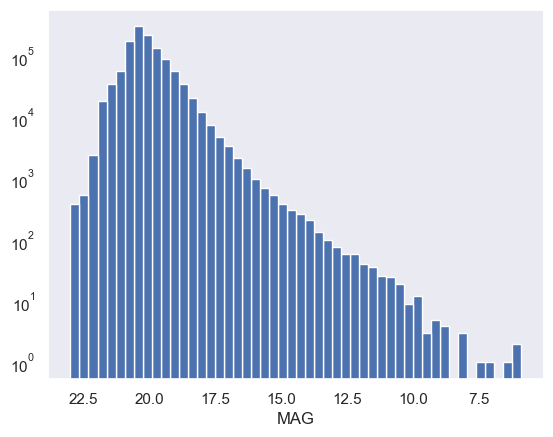

In [36]:
cat.MAG.hist(bins=50, edgecolor='white',
             grid=False);
plt.yscale('log')

plt.xlabel('MAG')
plt.gca().invert_xaxis()

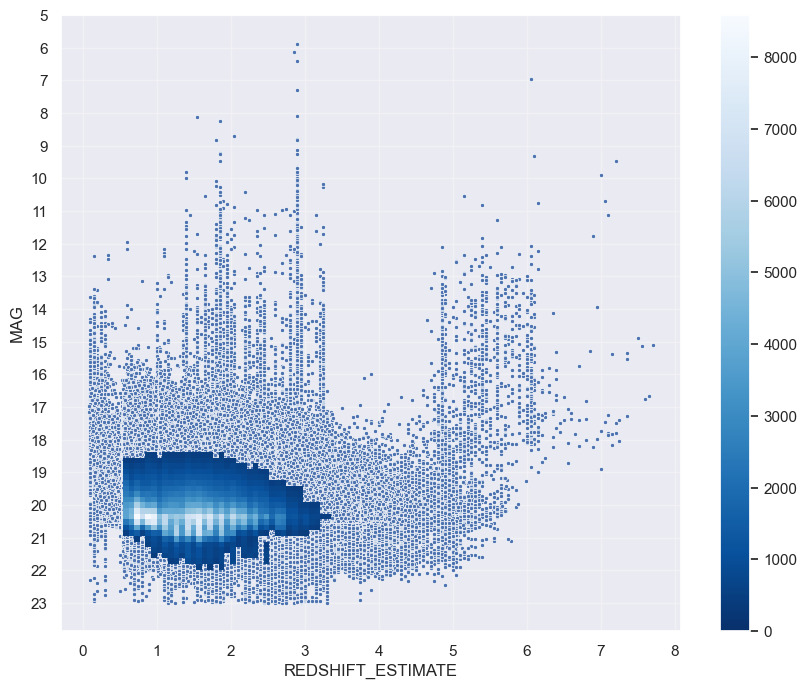

In [37]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', marker='.')
sns.histplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', bins=100, pthresh=.1, cmap="Blues_r", cbar=True)

plt.grid(True, alpha=0.3)

y_int_ticks = np.arange(int(plt.ylim()[0]), int(plt.ylim()[1])+1, 1)
plt.yticks(y_int_ticks)

plt.gca().invert_yaxis()

plt.show()

In [38]:
z_binsize = 0.10
mag_binsize = 0.2

# tails = cat.loc[(cat.REDSHIFT_ESTIMATE <= 0.2) | (cat.REDSHIFT_ESTIMATE >= 5.0)]
tails = cat.loc[cat.REDSHIFT_ESTIMATE >= 5.0]
dfs_to_concat = [tails]

# cat_all = cat.loc[(cat.REDSHIFT_ESTIMATE > 0.2) & (cat.REDSHIFT_ESTIMATE < 5.0)]
cat_all = cat.loc[cat.REDSHIFT_ESTIMATE < 5.0]

min_z = cat_all.REDSHIFT_ESTIMATE.min()
max_z = cat_all.REDSHIFT_ESTIMATE.max()

try:

    zs = np.arange(min_z, max_z, z_binsize)

    for i in range(len(zs)-1):

        # print("z range: ", zs[i], zs[i+1])
        
        sub_cat = cat_all[(cat_all.REDSHIFT_ESTIMATE>=zs[i]) & (cat_all.REDSHIFT_ESTIMATE<zs[i+1])]

        min_mag = sub_cat.MAG.min()
        max_mag = sub_cat.MAG.max()

        # print(min_mag, max_mag)

        try:

            mags = np.arange(min_mag, max_mag, mag_binsize)
            # print('mags', len(mags))

            for j in range(len(mags)-1):

                # print("range: ", mags[j], mags[j+1])

                subsub_cat = sub_cat[(sub_cat.MAG>=mags[j]) & (sub_cat.MAG<mags[j+1])]
                # print('subsub_cat', subsub_cat.shape[0])

                try: random_df = subsub_cat.sample(n=20, replace=False)
                except: random_df = subsub_cat
                # print('random_df', random_df.shape[0])

                # cat_bal = cat_bal.append(random_df, ignore_index=True)
                # cat_bal = pd.concat([cat_bal, random_df], ignore_index=True, axis=1)
                dfs_to_concat.append(random_df)

        except: print("could not create MAG bins")

except: print("could not create z bins")

cat_bal = pd.concat(dfs_to_concat, ignore_index=True)

In [39]:
cat_bal.shape

(28320, 118)

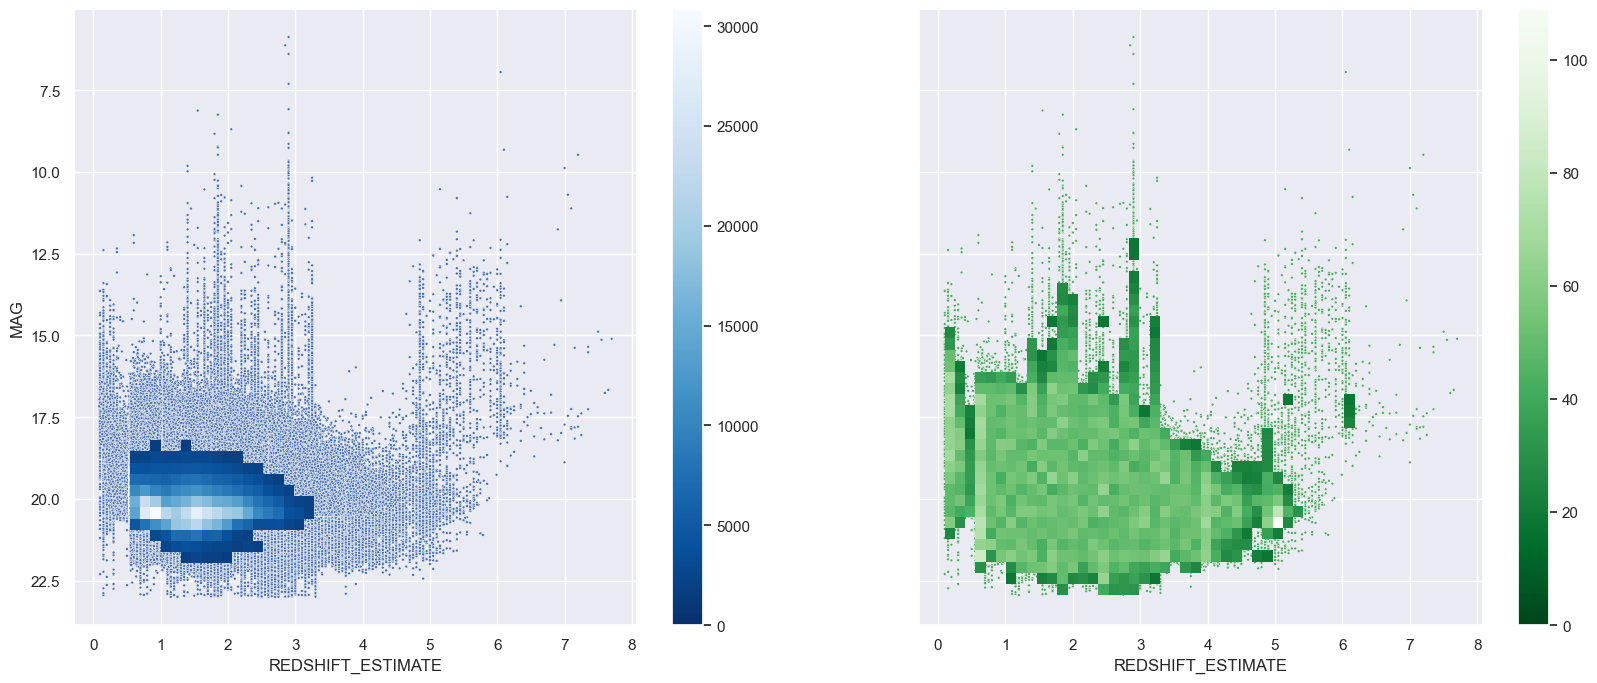

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 8))

sns.scatterplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax1, c='C0', size=1, legend=False)
sns.histplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Blues_r", cbar=True, ax=ax1)

sns.scatterplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax2, c='C2', size=1, legend=False)
sns.histplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Greens_r", cbar=True, ax=ax2)

ax1.set_gid(True)
ax2.set_gid(True)

plt.gca().invert_yaxis()

plt.show()

<Axes: >

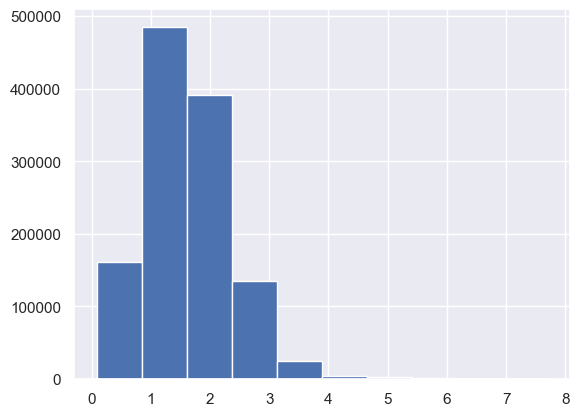

In [41]:
cat.REDSHIFT_ESTIMATE.hist()

<Axes: >

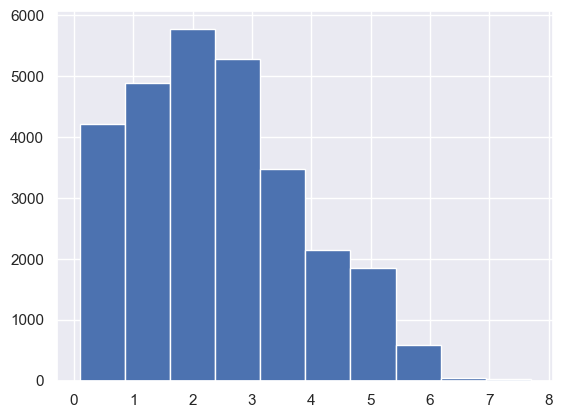

In [42]:
cat_bal.REDSHIFT_ESTIMATE.hist()

<Axes: >

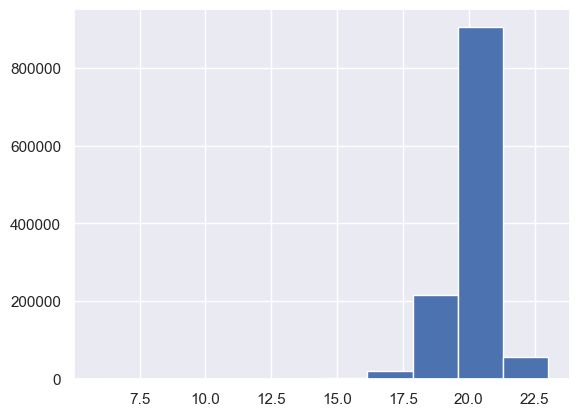

In [43]:
cat.MAG.hist()

<Axes: >

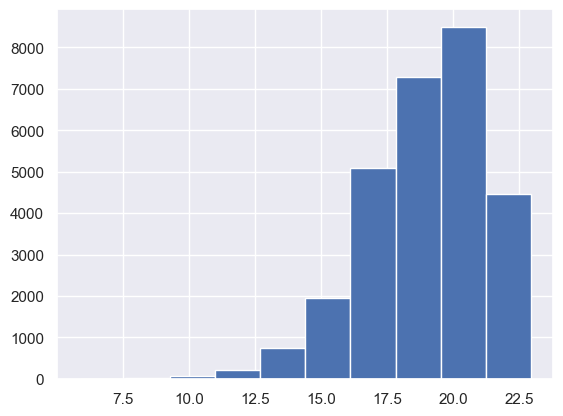

In [44]:
cat_bal.MAG.hist()

In [45]:
# save_to_fits(cat_bal, './../ByCycle_balanced_subset_QSOs.fits')
save_to_fits(cat_bal, './../../S17_Catalog/Catalogues/ByCycle_final_cat_april15/ByCycle_Final_Cat_with_all_S17_cols_plus_fobs_notna_balanced_set.fits')
save_to_fits(cat_bal, './../QSO_output/ByCycle_Final_Cat_plus_fobs_notna_balanced_set.fits')

# Change template name in cat to its simulated QSO

In [46]:
# cat_bal = pandas_from_fits('./../ByCycle_balanced_subset_QSOs.fits')
# cat_bal
# cat_test = pandas_from_fits('./../ByCycle_cat_not_in_balanced_training_set_subset.fits')
cat_test = pandas_from_fits('./../QSO_output/ByCycle_Final_Cat_plus_fobs_notna_balanced_set.fits')
cat_test

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,jd_obs_first,jd_obs_last,isky_mean,jd_last_observed,nob_observed,nrepeat,single_ob,dt_min,subsurvey_index,probsf
0,000m035-005m030,760213.0,0036m320,10350.0,REX,3.797036,-32.084532,0.015380,49.533257,-99.0,...,2.461330e+06,2.462006e+06,1.000000,2.461676e+06,1.0,0.0,0.0,0.0,129.0,1.0
1,000m035-005m030,760543.0,0036m320,10680.0,EXP,3.804881,-32.078050,0.015332,89.455704,-99.0,...,2.460870e+06,2.462006e+06,1.562500,2.461261e+06,1.0,0.0,0.0,0.0,129.0,1.0
2,000m035-005m030,1286020.0,0039m305,10099.0,PSF,4.045017,-30.408356,0.018470,191.900955,-99.0,...,2.461344e+06,2.462444e+06,1.529412,2.461599e+06,1.0,0.0,0.0,0.0,129.0,1.0
3,000m035-005m030,1430956.0,0049m340,4309.0,EXP,4.956523,-34.010734,0.011954,166.575058,-99.0,...,2.460978e+06,2.462681e+06,1.500000,2.460996e+06,1.0,0.0,0.0,0.0,129.0,1.0
4,000m040-005m035,822446.0,0022m352,4689.0,REX,2.199921,-35.333618,0.012128,1956.652100,-99.0,...,2.460914e+06,2.462682e+06,1.294118,2.460945e+06,1.0,0.0,0.0,0.0,129.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28315,150p000-155p005,171360.0,1511p025,15755.0,PSF,151.233402,2.549189,0.029747,76.838821,-99.0,...,2.461417e+06,2.461861e+06,1.000000,2.461861e+06,1.0,0.0,0.0,0.0,129.0,1.0
28316,175p000-180p005,635658.0,1763p022,662.0,REX,176.279032,2.182282,0.025585,5.874906,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0
28317,020m030-025m025,1902887.0,0226m275,10150.0,REX,22.751601,-27.417298,0.014187,27.009525,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0
28318,195p000-200p005,51317.0,1993p022,2475.0,REX,199.350097,2.325767,0.029110,7.399594,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0


In [47]:
qsos = pd.read_csv('../QSO_output/QSOs_with_fobs_balanced_set/model_input.csv')
qsos

,ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
0,QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845,7.00,-23.543716,0.052636,8.089223,-0.557916,MgIIBlueDeep_3.797m32.0845
1,QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078,7.10,-24.348564,0.003691,8.324254,-0.471009,MgIIBlueDeep_3.8049m32.078
2,QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084,5.35,-21.855946,0.074329,7.656040,-0.799842,MgIIBlueDeep_4.045m30.4084
3,QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107,5.15,-23.864170,0.018249,9.235309,-1.575821,MgIIBlueDeep_4.9565m34.0107
4,QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336,5.90,-24.404942,0.000813,8.278313,-0.402516,MgIIBlueDeep_2.1999m35.3336
...,...,...,...,...,...,...,...
31680,QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492,4.90,-21.793259,0.016154,7.863947,-1.032823,MgIIBlueDeep_151.2334p2.5492
31681,QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823,4.90,-24.595198,0.009459,9.215017,-1.263118,MgIIBlueDeep_176.279p2.1823
31682,QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173,4.95,-25.583225,0.016709,8.139061,0.208049,MgIIBlueDeep_22.7516m27.4173
31683,QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258,4.90,-23.322598,0.013690,8.500006,-1.057147,MgIIBlueDeep_199.3501p2.3258


In [55]:
# First, check if the qsos NAME values match the cat_test NAME values format
print(f"qsos NAME examples: {qsos['NAME'].iloc[:3].tolist()}")
print(f"cat_test NAME examples: {cat_test['NAME'].iloc[:3].tolist()}")

# Create a dictionary mapping from NAME to ID
qso_name_to_id = dict(zip(qsos['NAME'], qsos['ID'] + '.fits'))

# Update TEMPLATE field for each row in cat_test
cat_test['TEMPLATE'] = cat_test['NAME'].map(qso_name_to_id)

# Check if all names were matched correctly (this should return True if all names are properly matched)
print(f"All names matched: {cat_test['TEMPLATE'].notna().all()}")

# Show first few rows to verify the results
cat_test[['NAME', 'TEMPLATE']].head()

qsos NAME examples: ['MgIIBlueDeep_3.797m32.0845', 'MgIIBlueDeep_3.8049m32.078', 'MgIIBlueDeep_4.045m30.4084']
cat_test NAME examples: ['MgIIBlueDeep_3.797m32.0845', 'MgIIBlueDeep_3.8049m32.078', 'MgIIBlueDeep_4.045m30.4084']
All names matched: False


,NAME,TEMPLATE
0,MgIIBlueDeep_3.797m32.0845,QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845.fits
1,MgIIBlueDeep_3.8049m32.078,QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078.fits
2,MgIIBlueDeep_4.045m30.4084,QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084.fits
3,MgIIBlueDeep_4.9565m34.0107,QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107.fits
4,MgIIBlueDeep_2.1999m35.3336,QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336.fits


In [57]:
# cat_test['TEMPLATE'] = qsos.loc[qsos['NAME']==cat_test['NAME'], 'ID'] + '.fits'
cat_test['TEMPLATE']

0           QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845.fits
1           QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078.fits
2          QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084.fits
3         QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107.fits
4          QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336.fits
                              ...                       
28315     QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492.fits
28316      QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823.fits
28317    QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173.fits
28318     QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258.fits
28319    QSO_sim_z4.95_MgIIBlueDeep_206.3266p1.5839.fits
Name: TEMPLATE, Length: 28320, dtype: object

In [ ]:
cat_test = cat_test.loc[cat_test.TEMPLATE.notna()]

In [61]:
Counter(cat_test.TEMPLATE)

Counter({'QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845.fits': 1,
         'QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078.fits': 1,
         'QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084.fits': 1,
         'QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107.fits': 1,
         'QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336.fits': 1,
         'QSO_sim_z5.0_MgIIBlueDeep_9.9496m28.633.fits': 1,
         'QSO_sim_z5.1_MgIIBlueDeep_5.1696m29.5632.fits': 1,
         'QSO_sim_z5.4_MgIIBlueDeep_9.5976m31.8959.fits': 1,
         'QSO_sim_z5.05_MgIIBlueDeep_9.4335m35.0044.fits': 1,
         'QSO_sim_z6.05_MgIIBlueDeep_12.8007m28.3171.fits': 1,
         'QSO_sim_z5.35_MgIIBlueDeep_14.1336m34.735.fits': 1,
         'QSO_sim_z5.05_MgIIBlueDeep_14.0837m32.9974.fits': 1,
         'QSO_sim_z5.3_MgIIBlueDeep_14.0127m34.1448.fits': 1,
         'QSO_sim_z5.6_MgIIBlueDeep_12.919m33.5943.fits': 1,
         'QSO_sim_z5.1_MgIIBlueDeep_14.9389m35.4193.fits': 1,
         'QSO_sim_z5.0_MgIIBlueDeep_10.2221m35.5097.fits': 1,
         'QSO_sim

In [62]:
cat_test

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,jd_obs_first,jd_obs_last,isky_mean,jd_last_observed,nob_observed,nrepeat,single_ob,dt_min,subsurvey_index,probsf
0,000m035-005m030,760213.0,0036m320,10350.0,REX,3.797036,-32.084532,0.015380,49.533257,-99.0,...,2.461330e+06,2.462006e+06,1.000000,2.461676e+06,1.0,0.0,0.0,0.0,129.0,1.0
1,000m035-005m030,760543.0,0036m320,10680.0,EXP,3.804881,-32.078050,0.015332,89.455704,-99.0,...,2.460870e+06,2.462006e+06,1.562500,2.461261e+06,1.0,0.0,0.0,0.0,129.0,1.0
2,000m035-005m030,1286020.0,0039m305,10099.0,PSF,4.045017,-30.408356,0.018470,191.900955,-99.0,...,2.461344e+06,2.462444e+06,1.529412,2.461599e+06,1.0,0.0,0.0,0.0,129.0,1.0
3,000m035-005m030,1430956.0,0049m340,4309.0,EXP,4.956523,-34.010734,0.011954,166.575058,-99.0,...,2.460978e+06,2.462681e+06,1.500000,2.460996e+06,1.0,0.0,0.0,0.0,129.0,1.0
4,000m040-005m035,822446.0,0022m352,4689.0,REX,2.199921,-35.333618,0.012128,1956.652100,-99.0,...,2.460914e+06,2.462682e+06,1.294118,2.460945e+06,1.0,0.0,0.0,0.0,129.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28315,150p000-155p005,171360.0,1511p025,15755.0,PSF,151.233402,2.549189,0.029747,76.838821,-99.0,...,2.461417e+06,2.461861e+06,1.000000,2.461861e+06,1.0,0.0,0.0,0.0,129.0,1.0
28316,175p000-180p005,635658.0,1763p022,662.0,REX,176.279032,2.182282,0.025585,5.874906,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0
28317,020m030-025m025,1902887.0,0226m275,10150.0,REX,22.751601,-27.417298,0.014187,27.009525,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0
28318,195p000-200p005,51317.0,1993p022,2475.0,REX,199.350097,2.325767,0.029110,7.399594,-99.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,129.0,1.0


In [63]:
# save_to_fits(cat_bal, './../ByCycle_balanced_subset_QSOs.fits')
save_to_fits(cat_test, './../QSO_output/ByCycle_Final_Cat_plus_fobs_notna_balanced_set.fits')
# save_to_fits(cat_test, './../../S17_Catalog/Catalogues/ByCycle_final_cat_april15/ByCycle_Final_Cat_with_all_S17_cols_plus_fobs_notna_balanced_set.fits')

In [14]:
Counter(cat_bal.SUBSURVEY)

Counter({'MgIIGreen': 9727,
         'DLABlue': 6628,
         'MgIIBlueDeep': 6459,
         'MgIIBlueWide': 4552,
         'LLSBlue': 4319})

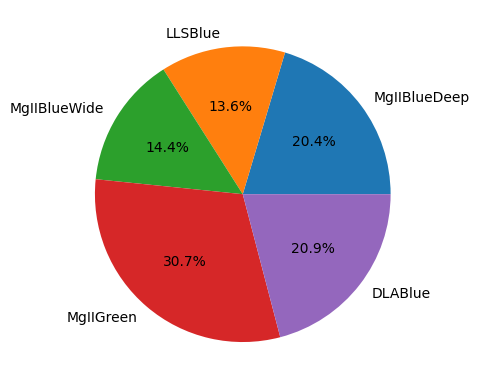

In [16]:
fig, ax = plt.subplots()
ax.pie(Counter(cat_bal.SUBSURVEY).values(), labels=Counter(cat_bal.SUBSURVEY).keys(), autopct='%1.1f%%')
plt.show()

In [26]:
1.2 * (31685 / 10)# / 3600  # hours for ETC

3802.2

In [58]:
save_to_fits(cat_test, './../ByCycle_cat_not_in_balanced_training_set_subset.fits')

# Objects not in the training set

In [7]:
cat_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_3.797m32.0845,3.797036,-32.084532,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.582340,29.000000,0.113706,0.060229,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_3.8049m32.078,3.804881,-32.078050,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.408802,29.000000,0.103468,0.029969,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_4.045m30.4084,4.045017,-30.408356,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.680607,0.052875,0.023544,0.005908,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_4.9565m34.0107,4.956523,-34.010734,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.239796,0.676440,0.026675,0.006518,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_2.1999m35.3336,2.199921,-35.333618,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,16.874743,29.000000,0.002459,0.000740,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31680,MgIIBlueDeep_151.2334p2.5492,151.233402,2.549189,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.938766,2.205216,0.042353,0.014130,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31681,MgIIBlueDeep_176.279p2.1823,176.279032,2.182282,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.854259,29.000000,0.359425,0.184809,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31682,MgIIBlueDeep_22.7516m27.4173,22.751601,-27.417298,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.629225,29.000000,0.146640,0.040198,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31683,MgIIBlueDeep_199.3501p2.3258,199.350097,2.325767,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.753094,29.000000,0.466469,0.146729,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [5]:
cat

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_2.855m28.8672,2.854988,-28.867229,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.669659,0.018090,0.015493,0.025530,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_2.9957m28.6353,2.995691,-28.635296,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.635201,0.015942,0.011556,0.023731,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_2.9987m28.6959,2.998681,-28.695906,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.051962,0.013067,0.009702,0.023663,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_3.0071m28.6312,3.007118,-28.631196,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.557556,0.008148,0.006187,0.009784,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_3.1042m28.7464,3.104241,-28.746363,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.649572,0.006044,0.005409,0.009769,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361478,MgIIGreen_316.0221m3.9022,316.022099,-3.902170,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.377794,0.066010,1.000000,0.058824,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361479,MgIIGreen_315.8218m3.8123,315.821750,-3.812265,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,18.731197,0.048560,1.000000,0.052594,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361480,MgIIGreen_315.6156m3.7137,315.615635,-3.713714,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.772379,0.112214,1.000000,0.133392,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361481,MgIIGreen_315.9049m3.6779,315.904928,-3.677880,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.577539,0.133799,1.000000,0.068531,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [25]:
list(cat.columns)

['NAME',
 'RA',
 'DEC',
 'PMRA',
 'PMDEC',
 'EPOCH',
 'RESOLUTION',
 'SUBSURVEY',
 'TEMPLATE',
 'RULESET',
 'EXTENT_FLAG',
 'EXTENT_PARAMETER',
 'EXTENT_INDEX',
 'MAG_TYPE',
 'MAG',
 'MAG_ERR',
 'DATE_EARLIEST',
 'DATE_LATEST',
 'CADENCE',
 'REDDENING',
 'REDSHIFT_ESTIMATE',
 'REDSHIFT_ERROR',
 'TEMPLATE_REDSHIFT',
 'CAL_MAG_BLUE',
 'CAL_MAG_GREEN',
 'CAL_MAG_RED',
 'CAL_MAG_ERR_BLUE',
 'CAL_MAG_ERR_GREEN',
 'CAL_MAG_ERR_RED',
 'CAL_MAG_ID_BLUE',
 'CAL_MAG_ID_GREEN',
 'CAL_MAG_ID_RED',
 'CLASSIFICATION',
 'COMPLETENESS',
 'PARALLAX']

In [31]:
cat_not_in_bal = cat.merge(cat_bal, how='left', on=['NAME'], indicator=True)
cat_not_in_bal = cat_not_in_bal.loc[cat_not_in_bal['_merge'] == 'left_only']

In [32]:
cat_not_in_bal

,NAME,RA_x,DEC_x,PMRA_x,PMDEC_x,EPOCH_x,RESOLUTION_x,SUBSURVEY_x,TEMPLATE_x,RULESET_x,...,CAL_MAG_ERR_BLUE_y,CAL_MAG_ERR_GREEN_y,CAL_MAG_ERR_RED_y,CAL_MAG_ID_BLUE_y,CAL_MAG_ID_GREEN_y,CAL_MAG_ID_RED_y,CLASSIFICATION_y,COMPLETENESS_y,PARALLAX_y,_merge
0,MgIIBlueDeep_2.855m28.8672,2.854988,-28.867229,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
1,MgIIBlueDeep_2.9957m28.6353,2.995691,-28.635296,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
2,MgIIBlueDeep_2.9987m28.6959,2.998681,-28.695906,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
3,MgIIBlueDeep_3.0071m28.6312,3.007118,-28.631196,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
4,MgIIBlueDeep_3.1042m28.7464,3.104241,-28.746363,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361478,MgIIGreen_316.0221m3.9022,316.022099,-3.902170,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
1361479,MgIIGreen_315.8218m3.8123,315.821750,-3.812265,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
1361480,MgIIGreen_315.6156m3.7137,315.615635,-3.713714,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only
1361481,MgIIGreen_315.9049m3.6779,315.904928,-3.677880,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,left_only


In [33]:
cat_not_in_bal.shape[0] + cat_bal.shape[0] == cat.shape[0]

True

In [ ]:
drop_col = ['_merge']
rename_cols = []

for col in cat_not_in_bal.columns:
    if col.endswith('_y'):
        drop_col.append(col)
    
    elif col.endswith('_x'):
        rename_cols.append(col)

    else:
        pass

In [45]:
rename_dic = {}

for col in rename_cols:
    rename_dic[col] = col[:(len(col)-2)]

rename_dic

{'RA_x': 'RA',
 'DEC_x': 'DEC',
 'PMRA_x': 'PMRA',
 'PMDEC_x': 'PMDEC',
 'EPOCH_x': 'EPOCH',
 'RESOLUTION_x': 'RESOLUTION',
 'SUBSURVEY_x': 'SUBSURVEY',
 'TEMPLATE_x': 'TEMPLATE',
 'RULESET_x': 'RULESET',
 'EXTENT_FLAG_x': 'EXTENT_FLAG',
 'EXTENT_PARAMETER_x': 'EXTENT_PARAMETER',
 'EXTENT_INDEX_x': 'EXTENT_INDEX',
 'MAG_TYPE_x': 'MAG_TYPE',
 'MAG_x': 'MAG',
 'MAG_ERR_x': 'MAG_ERR',
 'DATE_EARLIEST_x': 'DATE_EARLIEST',
 'DATE_LATEST_x': 'DATE_LATEST',
 'CADENCE_x': 'CADENCE',
 'REDDENING_x': 'REDDENING',
 'REDSHIFT_ESTIMATE_x': 'REDSHIFT_ESTIMATE',
 'REDSHIFT_ERROR_x': 'REDSHIFT_ERROR',
 'TEMPLATE_REDSHIFT_x': 'TEMPLATE_REDSHIFT',
 'CAL_MAG_BLUE_x': 'CAL_MAG_BLUE',
 'CAL_MAG_GREEN_x': 'CAL_MAG_GREEN',
 'CAL_MAG_RED_x': 'CAL_MAG_RED',
 'CAL_MAG_ERR_BLUE_x': 'CAL_MAG_ERR_BLUE',
 'CAL_MAG_ERR_GREEN_x': 'CAL_MAG_ERR_GREEN',
 'CAL_MAG_ERR_RED_x': 'CAL_MAG_ERR_RED',
 'CAL_MAG_ID_BLUE_x': 'CAL_MAG_ID_BLUE',
 'CAL_MAG_ID_GREEN_x': 'CAL_MAG_ID_GREEN',
 'CAL_MAG_ID_RED_x': 'CAL_MAG_ID_RED',
 'CLA

In [46]:
cat_not_in_bal.drop(columns=drop_col, inplace=True)
cat_not_in_bal.rename(columns=rename_dic, inplace=True)
cat_not_in_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_2.855m28.8672,2.854988,-28.867229,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.669659,0.018090,0.015493,0.025530,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_2.9957m28.6353,2.995691,-28.635296,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.635201,0.015942,0.011556,0.023731,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_2.9987m28.6959,2.998681,-28.695906,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.051962,0.013067,0.009702,0.023663,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_3.0071m28.6312,3.007118,-28.631196,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.557556,0.008148,0.006187,0.009784,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_3.1042m28.7464,3.104241,-28.746363,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.649572,0.006044,0.005409,0.009769,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361478,MgIIGreen_316.0221m3.9022,316.022099,-3.902170,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.377794,0.066010,1.000000,0.058824,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361479,MgIIGreen_315.8218m3.8123,315.821750,-3.812265,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,18.731197,0.048560,1.000000,0.052594,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361480,MgIIGreen_315.6156m3.7137,315.615635,-3.713714,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.772379,0.112214,1.000000,0.133392,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1361481,MgIIGreen_315.9049m3.6779,315.904928,-3.677880,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.577539,0.133799,1.000000,0.068531,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [52]:
small_cat_not_in_bal = cat_not_in_bal.sample(10000, random_state=42)

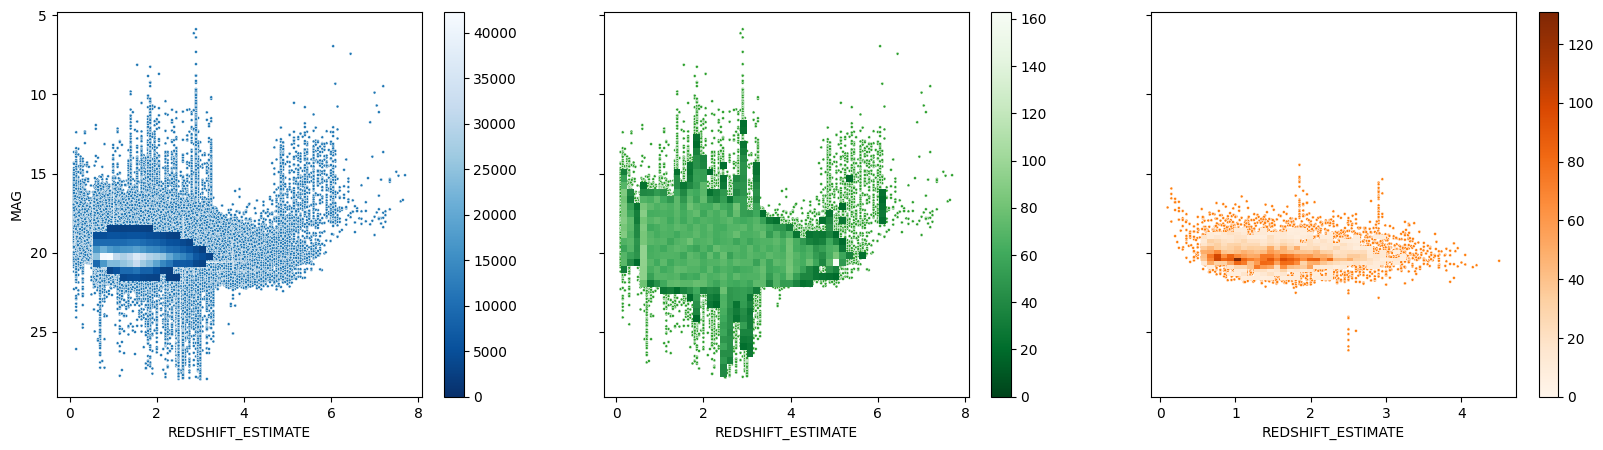

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 5))

sns.scatterplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax1, c='C0', size=1, legend=False)
sns.histplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Blues_r", cbar=True, ax=ax1)

sns.scatterplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax2, c='C2', size=1, legend=False)
sns.histplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Greens_r", cbar=True, ax=ax2)

sns.scatterplot(data=small_cat_not_in_bal, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax3, c='C1', size=1, legend=False)
sns.histplot(data=small_cat_not_in_bal, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Oranges", cbar=True, ax=ax3)

ax1.set_gid(True)
ax2.set_gid(True)

plt.gca().invert_yaxis()

plt.show()

In [ ]:
# save_to_fits(small_cat_not_in_bal, './../ByCycle_cat_not_in_balanced_training_set_subset.fits')
# save_to_fits(cat_not_in_bal, './../ByCycle_cat_not_in_balanced_training_set.fits')

# Fobs

In [69]:
cat_fobs = pandas_from_fits('./../../S17_Catalog/Catalogues/ByCycle_final_cat_april15/ByCycle_Final_Cat_with_all_S17_cols_plus_fobs.fits')
cat_fobs

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,jd_obs_first,jd_obs_last,isky_mean,jd_last_observed,nob_observed,nrepeat,single_ob,dt_min,subsurvey_index,probsf
0,000m030-005m025,16955.0,0029m287,425.0,REX,2.854988,-28.867229,0.016329,70.079727,-99.000000,...,2.460901e+06,2.460962e+06,2.200000,2.460962e+06,1.0,0.0,0.0,0.0,129.0,1.0
1,000m030-005m025,21473.0,0029m287,5019.0,REX,2.995691,-28.635296,0.013518,93.950668,-99.000000,...,2.461263e+06,2.461591e+06,1.000000,2.461591e+06,1.0,0.0,0.0,0.0,129.0,1.0
2,000m030-005m025,21547.0,0029m287,5097.0,PSF,2.998681,-28.695906,0.014227,111.909660,-99.000000,...,2.461263e+06,2.461591e+06,1.000000,2.461591e+06,1.0,0.0,0.0,0.0,129.0,1.0
3,000m030-005m025,21765.0,0029m287,5323.0,SER,3.007118,-28.631196,0.013384,175.493042,-99.000000,...,2.460962e+06,2.462307e+06,1.153846,2.460962e+06,0.0,0.0,0.0,0.0,129.0,1.0
4,000m030-005m025,24879.0,0029m287,8506.0,PSF,3.104241,-28.746363,0.013091,200.720352,0.052104,...,2.460901e+06,2.462444e+06,1.636364,2.460962e+06,1.0,0.0,0.0,0.0,129.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361479,-,-999.0,-,-999.0,-,316.022099,-3.902170,-999.000000,-999.000000,-999.000000,...,2.460922e+06,2.460922e+06,3.000000,2.460922e+06,1.0,0.0,0.0,0.0,131.0,1.0
1361480,-,-999.0,-,-999.0,-,315.821750,-3.812265,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0
1361481,-,-999.0,-,-999.0,-,315.615635,-3.713714,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0
1361482,-,-999.0,-,-999.0,-,315.904928,-3.677880,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0


In [70]:
cat_fobs['TEMPLATE']

0          4M_templ_z1_00_extended.fits
1          4M_templ_z1_00_extended.fits
2          4M_templ_z1_00_extended.fits
3          4M_templ_z1_00_extended.fits
4          4M_templ_z1_00_extended.fits
                       ...             
1361479    4M_templ_z1_00_extended.fits
1361480    4M_templ_z1_00_extended.fits
1361481    4M_templ_z1_00_extended.fits
1361482    4M_templ_z1_00_extended.fits
1361483    4M_templ_z1_00_extended.fits
Name: TEMPLATE, Length: 1361484, dtype: string

In [71]:
cat_fobs_notna = cat_fobs.loc[cat_fobs['fobs'] >= 0.0]
cat_fobs_notna

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,jd_obs_first,jd_obs_last,isky_mean,jd_last_observed,nob_observed,nrepeat,single_ob,dt_min,subsurvey_index,probsf
0,000m030-005m025,16955.0,0029m287,425.0,REX,2.854988,-28.867229,0.016329,70.079727,-99.000000,...,2.460901e+06,2.460962e+06,2.200000,2.460962e+06,1.0,0.0,0.0,0.0,129.0,1.0
1,000m030-005m025,21473.0,0029m287,5019.0,REX,2.995691,-28.635296,0.013518,93.950668,-99.000000,...,2.461263e+06,2.461591e+06,1.000000,2.461591e+06,1.0,0.0,0.0,0.0,129.0,1.0
2,000m030-005m025,21547.0,0029m287,5097.0,PSF,2.998681,-28.695906,0.014227,111.909660,-99.000000,...,2.461263e+06,2.461591e+06,1.000000,2.461591e+06,1.0,0.0,0.0,0.0,129.0,1.0
3,000m030-005m025,21765.0,0029m287,5323.0,SER,3.007118,-28.631196,0.013384,175.493042,-99.000000,...,2.460962e+06,2.462307e+06,1.153846,2.460962e+06,0.0,0.0,0.0,0.0,129.0,1.0
4,000m030-005m025,24879.0,0029m287,8506.0,PSF,3.104241,-28.746363,0.013091,200.720352,0.052104,...,2.460901e+06,2.462444e+06,1.636364,2.460962e+06,1.0,0.0,0.0,0.0,129.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361479,-,-999.0,-,-999.0,-,316.022099,-3.902170,-999.000000,-999.000000,-999.000000,...,2.460922e+06,2.460922e+06,3.000000,2.460922e+06,1.0,0.0,0.0,0.0,131.0,1.0
1361480,-,-999.0,-,-999.0,-,315.821750,-3.812265,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0
1361481,-,-999.0,-,-999.0,-,315.615635,-3.713714,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0
1361482,-,-999.0,-,-999.0,-,315.904928,-3.677880,-999.000000,-999.000000,-999.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,131.0,1.0


In [72]:
save_to_fits(cat_fobs_notna, './../../S17_Catalog/Catalogues/ByCycle_final_cat_april15/ByCycle_Final_Cat_with_all_S17_cols_plus_fobs_notna.fits')

In [17]:
for col in cat_fobs.columns:
    print(col)

SWEEP_NAME
INDEX_SWEEP
BRICKNAME
OBJID
TYPE
RA
DEC
EBV
SN_MAX
PLXSIG
PMSIG
BAND_LEGACY
REFERENCE_BAND
COMBINATION_USE
CAL_MAG_BLUE
CAL_MAG_GREEN
CAL_MAG_RED
MAG
CAL_MAG_ERR_BLUE
CAL_MAG_ERR_GREEN
CAL_MAG_ERR_RED
MAG_ERR
MAG_Y
MAG_J
MAG_H
MAG_K
MAGERR_Y
MAGERR_J
MAGERR_H
MAGERR_K
MAG_W1
MAG_W2
MAGERR_W1
MAGERR_W2
P_QSO
REDSHIFT_ESTIMATE
Z1_QSO
Z2_QSO
P_QSO_Z
P_GALAXY
PHOTOZ_GALAXY
Z1_GALAXY
Z2_GALAXY
P_GALAXY_Z
P_STAR
RATIO
CLASS_SPEC
Z_SPEC
REDSHIFT_ERROR
REDSHIFT_REF
l
b
pm
PMRA
PMDEC
pmra_error
pmdec_error
Z_DESI
SPECTYPE_DESI
SUBSURVEY
EPOCH
RESOLUTION
CADENCE
TEMPLATE
EXTENT_FLAG
EXTENT_PARAMETER
EXTENT_INDEX
REDDENING
TEMPLATE_REDSHIFT
DATE_EARLIEST
DATE_LATEST
CLASSIFICATION
COMPLETENESS
PARALLAX
MAG_TYPE
CAL_MAG_ID_BLUE
CAL_MAG_ID_GREEN
CAL_MAG_ID_RED
RULESET
NAME
targ_id
u_obj_id
ra
dec
resolution
date_earliest
date_latest
fcompl
subsurvey_id
texp_d
texp_g
texp_b
texp_s
status
tfrac_req
fobs_initial
fobs
fobs_max
fobs_remain
fobs_est
wremain
target_value_max
ntile
nob
ntile_obs

In [73]:
cat_fobs.shape[0] - cat_fobs.loc[cat_fobs['fobs']>-1.0].shape[0]

158661

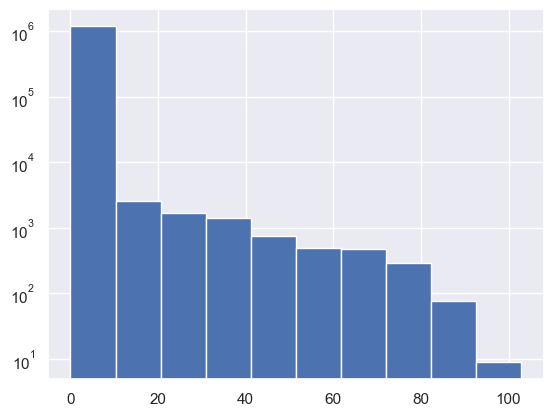

In [12]:
cat_fobs.loc[cat_fobs['fobs']>-1.0]['fobs'].hist();

plt.yscale('log')

In [ ]:
# cat_not_bal = pandas_from_fits('./../ByCycle_cat_not_in_balanced_training_set.fits')
# cat_not_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_2.855m28.8672,2.854988,-28.867229,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.669659,0.018090,0.015493,0.025530,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_2.9957m28.6353,2.995691,-28.635296,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.635201,0.015942,0.011556,0.023731,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_2.9987m28.6959,2.998681,-28.695906,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.051962,0.013067,0.009702,0.023663,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_3.0071m28.6312,3.007118,-28.631196,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.557556,0.008148,0.006187,0.009784,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_3.1042m28.7464,3.104241,-28.746363,0.0,0.0,2000.0,2,MgIIBlueDeep,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.649572,0.006044,0.005409,0.009769,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329793,MgIIGreen_316.0221m3.9022,316.022099,-3.902170,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.377794,0.066010,1.000000,0.058824,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1329794,MgIIGreen_315.8218m3.8123,315.821750,-3.812265,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,18.731197,0.048560,1.000000,0.052594,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1329795,MgIIGreen_315.6156m3.7137,315.615635,-3.713714,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.772379,0.112214,1.000000,0.133392,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1329796,MgIIGreen_315.9049m3.6779,315.904928,-3.677880,0.0,0.0,2000.0,2,MgIIGreen,4M_templ_z1_00_extended.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.577539,0.133799,1.000000,0.068531,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [76]:
# First, check if the qsos NAME values match the cat_test NAME values format
print(f"qsos NAME examples: {qsos['NAME'].iloc[:3].tolist()}")
print(f"cat_test NAME examples: {cat_fobs['NAME'].iloc[:3].tolist()}")

# Create a dictionary mapping from NAME to ID
qso_name_to_id = dict(zip(qsos['NAME'], qsos['ID'] + '.fits'))

# Update TEMPLATE field for each row in cat_test
cat_fobs['TEMPLATE'] = cat_fobs['NAME'].map(qso_name_to_id)

qsos NAME examples: ['MgIIBlueDeep_3.797m32.0845', 'MgIIBlueDeep_3.8049m32.078', 'MgIIBlueDeep_4.045m30.4084']
cat_test NAME examples: ['MgIIBlueDeep_2.855m28.8672', 'MgIIBlueDeep_2.9957m28.6353', 'MgIIBlueDeep_2.9987m28.6959']


In [78]:
cat_fobs[['NAME', 'TEMPLATE']]

,NAME,TEMPLATE
0,MgIIBlueDeep_2.855m28.8672,NaN
1,MgIIBlueDeep_2.9957m28.6353,NaN
2,MgIIBlueDeep_2.9987m28.6959,NaN
3,MgIIBlueDeep_3.0071m28.6312,NaN
4,MgIIBlueDeep_3.1042m28.7464,NaN
...,...,...
1361479,MgIIGreen_316.0221m3.9022,NaN
1361480,MgIIGreen_315.8218m3.8123,NaN
1361481,MgIIGreen_315.6156m3.7137,NaN
1361482,MgIIGreen_315.9049m3.6779,NaN


# High fobs

In [ ]:
cat_high_fobs = cat_fobs.copy()
cat_high_fobs.shape

(10987, 118)

In [65]:
cat_high_fobs.loc[cat_high_fobs['SUBSURVEY'] == 'MgIIBlueDeep', 'fobs'] = 10.0
cat_high_fobs.loc[cat_high_fobs['SUBSURVEY'] != 'MgIIBlueDeep', 'fobs'] = 2.0

In [74]:
qsos

,ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
0,QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845,7.00,-23.543716,0.052636,8.089223,-0.557916,MgIIBlueDeep_3.797m32.0845
1,QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078,7.10,-24.348564,0.003691,8.324254,-0.471009,MgIIBlueDeep_3.8049m32.078
2,QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084,5.35,-21.855946,0.074329,7.656040,-0.799842,MgIIBlueDeep_4.045m30.4084
3,QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107,5.15,-23.864170,0.018249,9.235309,-1.575821,MgIIBlueDeep_4.9565m34.0107
4,QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336,5.90,-24.404942,0.000813,8.278313,-0.402516,MgIIBlueDeep_2.1999m35.3336
...,...,...,...,...,...,...,...
31680,QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492,4.90,-21.793259,0.016154,7.863947,-1.032823,MgIIBlueDeep_151.2334p2.5492
31681,QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823,4.90,-24.595198,0.009459,9.215017,-1.263118,MgIIBlueDeep_176.279p2.1823
31682,QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173,4.95,-25.583225,0.016709,8.139061,0.208049,MgIIBlueDeep_22.7516m27.4173
31683,QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258,4.90,-23.322598,0.013690,8.500006,-1.057147,MgIIBlueDeep_199.3501p2.3258


In [ ]:
# First, check if the qsos NAME values match the cat_test NAME values format
print(f"qsos NAME examples: {qsos['NAME'].iloc[:3].tolist()}")
print(f"cat_test NAME examples: {cat_test['NAME'].iloc[:3].tolist()}")

# Create a dictionary mapping from NAME to ID
qso_name_to_id = dict(zip(qsos['NAME'], qsos['ID'] + '.fits'))

# Update TEMPLATE field for each row in cat_test
cat_test['TEMPLATE'] = cat_test['NAME'].map(qso_name_to_id)

# Check if all names were matched correctly (this should return True if all names are properly matched)
print(f"All names matched: {cat_test['TEMPLATE'].notna().all()}")

# Show first few rows to verify the results
cat_test[['NAME', 'TEMPLATE']].head()

In [66]:
Counter(cat_high_fobs['fobs'])

Counter({2.0: 8882, 10.0: 2105})

In [67]:
save_to_fits(cat_high_fobs, './../QSO_output/ByCycle_Final_Cat_plus_high_fobs_notna_balanced_set.fits')

In [68]:
cat_high_fobs['TEMPLATE']

0           QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845.fits
1           QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078.fits
2          QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084.fits
3         QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107.fits
4          QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336.fits
                              ...                       
28315     QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492.fits
28316      QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823.fits
28317    QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173.fits
28318     QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258.fits
28319    QSO_sim_z4.95_MgIIBlueDeep_206.3266p1.5839.fits
Name: TEMPLATE, Length: 10987, dtype: object